<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.c.autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/neural_network_tools.py

! pip install livelossplot

from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector
from neural_network_tools import enforce_reproducibility, make_sequential_model, train_model



# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile
import datetime
import shutil
from functools import partial, partialmethod

# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime
%load_ext autotime

--2025-11-14 22:02:44--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2025-11-14 22:02:45 (56.9 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2025-11-14 22:02:45--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP

### Mount google drive

In [2]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/06.clustering-and-anomaly/'

Mounted at /content/gdrive
time: 47 s (started: 2025-11-14 22:03:16 +00:00)


### Preprocessing

The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [3]:

#Download link updated
! wget -O creditcard.csv \
  "https://dl.dropboxusercontent.com/scl/fi/6n89gfhs4fg3xetlc04dd/creditcard.csv?rlkey=mkboeg92cpnkinhvmeus3ek09"

df = pd.read_csv('creditcard.csv')


df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']]

--2025-11-14 22:04:03--  https://dl.dropboxusercontent.com/scl/fi/6n89gfhs4fg3xetlc04dd/creditcard.csv?rlkey=mkboeg92cpnkinhvmeus3ek09
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 144.11M  26.9MB/s    in 6.3s    

2025-11-14 22:04:11 (22.7 MB/s) - ‘creditcard.csv’ saved [151114991/151114991]

time: 15.3 s (started: 2025-11-14 22:04:03 +00:00)


To perform model selection, i.e., selecting the best configuration, we will use the ground truth (the normal-anomaly label) and compute the precision-recall curves and the ROC curve.

To avoid **data leakage**, we perform model selection on the training set only

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                      random_state=9)


time: 213 ms (started: 2025-11-14 22:04:19 +00:00)



We also scale the dataset.

In [5]:
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)

time: 75.2 ms (started: 2025-11-14 22:04:19 +00:00)


In [6]:
n_features = X_tr_scaled.shape[1]
print("The number of features is ", n_features)


The number of features is  29
time: 3.38 ms (started: 2025-11-14 22:04:19 +00:00)


# Autoencoder

In [7]:
first_architecture = [10, 5, 10, n_features]
# The encoder is composed of the input layer, with one input per feature
#    and a layer of 10 neurons
# The latent representation is composed of one layer of 5 neurons
# The decoder is composed of a layer of 10 neurons and the output layer
#

time: 1.83 ms (started: 2025-11-14 22:04:19 +00:00)


Instead of always calling `make_sequential_model(..)` specifying many parameters (that will basically not change all over this notebook, let us use the function `partial` from Python `functools` library

In [8]:
make_autoencoder = partial(make_sequential_model, sample_size=n_features,
                        hidden_activation_function='tanh',
                      out_activation_function='tanh',
                      loss_fun='mean_squared_error',
                      metrics=[])

time: 651 µs (started: 2025-11-14 22:04:19 +00:00)


We can now call directly this function `make_autoencoder`

In [9]:
model = make_autoencoder(layer_sizes=first_architecture)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


time: 2.98 s (started: 2025-11-14 22:04:19 +00:00)


We can now train this model

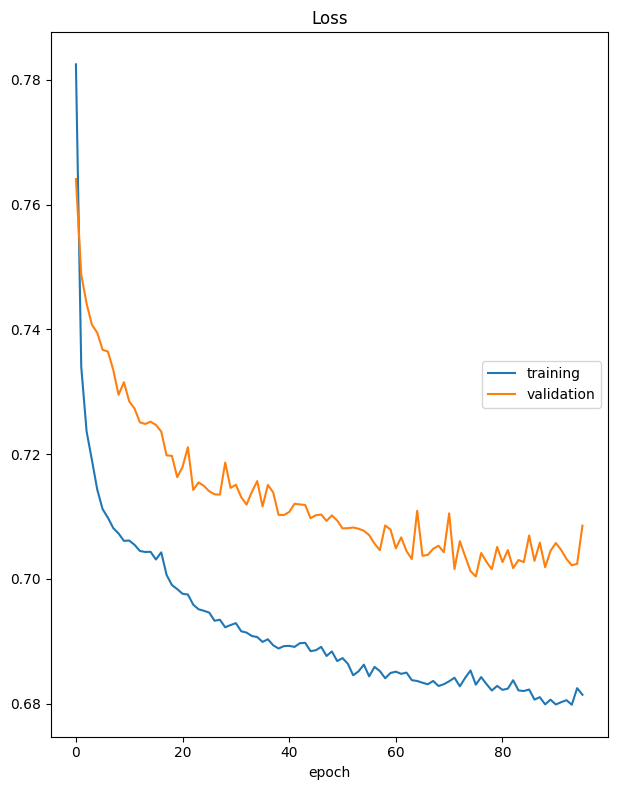

Loss
	training         	 (min:    0.680, max:    0.783, cur:    0.681)
	validation       	 (min:    0.700, max:    0.764, cur:    0.709)
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7010 - val_loss: 0.7085
Epoch 96: early stopping
Restoring model weights from the end of the best epoch: 76.
time: 17min 34s (started: 2025-11-14 22:04:22 +00:00)


In [10]:
nn_file = my_path + 'nn1.h5'

history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5,
                      max_epochs=200)

The validation loss stops to decrease too soon (only after 50 epochs). It may be due to the learning rate being too high (in the declaration of the function `make_sequential_model`, the default learning rate is 0.02). Let's try with a smaller one

In [11]:
model = make_autoencoder(layer_sizes=first_architecture, learning_rate=0.001)

time: 52.5 ms (started: 2025-11-14 22:21:56 +00:00)


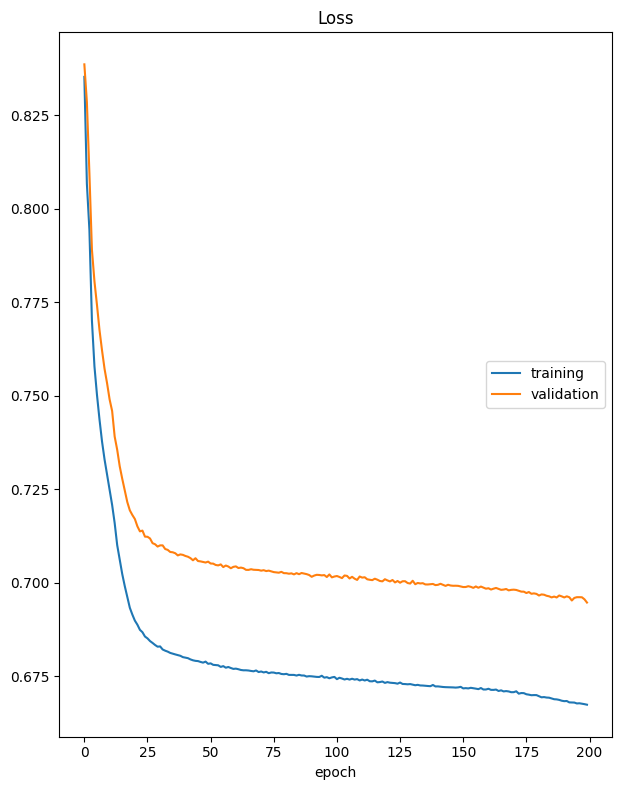

Loss
	training         	 (min:    0.667, max:    0.835, cur:    0.667)
	validation       	 (min:    0.695, max:    0.839, cur:    0.695)
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.6877 - val_loss: 0.6947
Restoring model weights from the end of the best epoch: 200.
time: 36min 56s (started: 2025-11-14 22:21:57 +00:00)


In [12]:
nn_file = my_path + 'nn1-lr_0.001.h5'
history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5,
                      max_epochs=200)

We did not manage to remarkably decrease the loss.

Let's anyways try to see if we can construct a decent anomaly detector.

# First Anomaly detector

## Model selection: selecting the threshold

The **anomaly score** of each sample is the reconstruction error.

In [13]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

4451/4451 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
time: 9.11 s (started: 2025-11-14 22:58:53 +00:00)


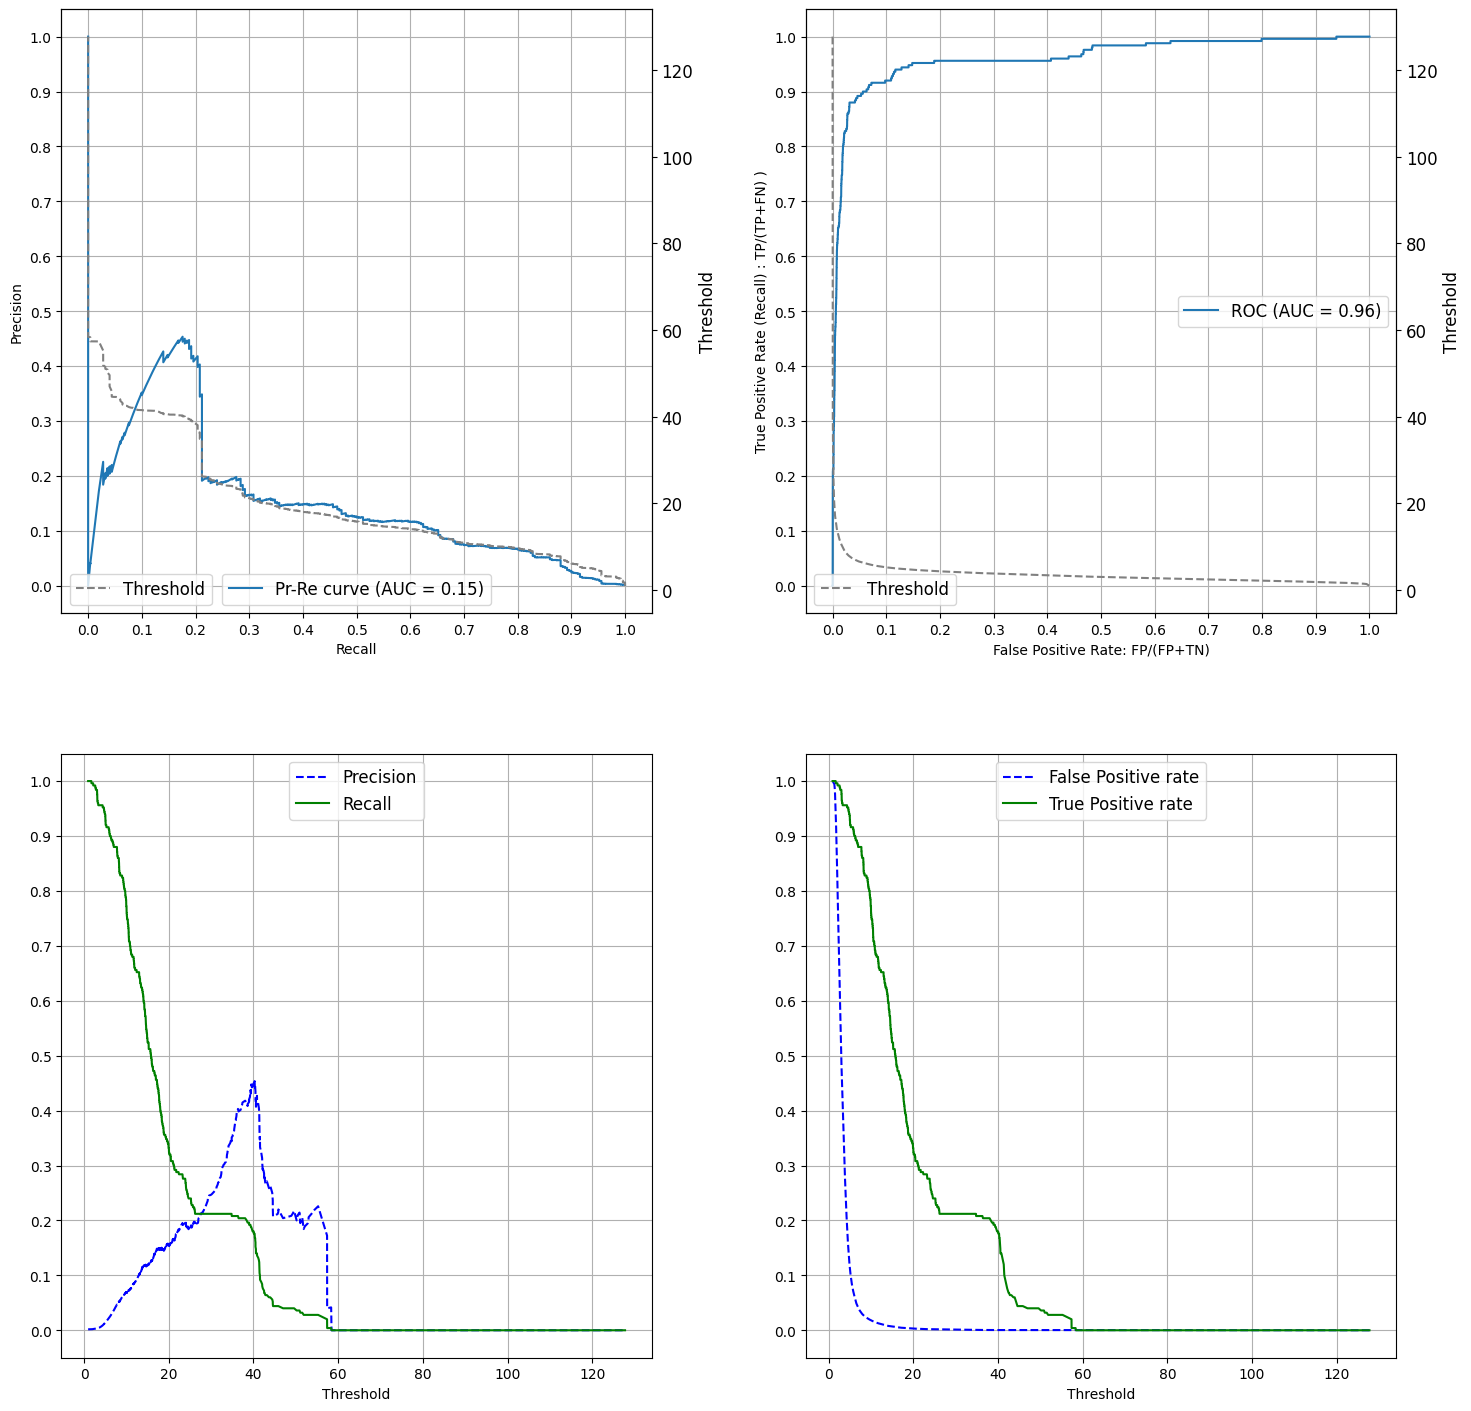

time: 1.99 s (started: 2025-11-14 22:59:02 +00:00)


In [14]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Look at the ROC curve (top right figure). It is possible to have a True Positive Rate (Recall) >= 90%, while having a false positive rate <= 10%.
In other words, we can construct an anomaly detector able to find 90% of the anomalies with less than 10% of false alarms.

Looking at the grey curve on that plot, we see that such a configuration is for threshold of about 5. Let us search for a good value of threshold.

Precision= 0.014005266937993775
Recall= 0.936
False Positive Rate =  0.11588921795530169
True Positive Rate =  0.936


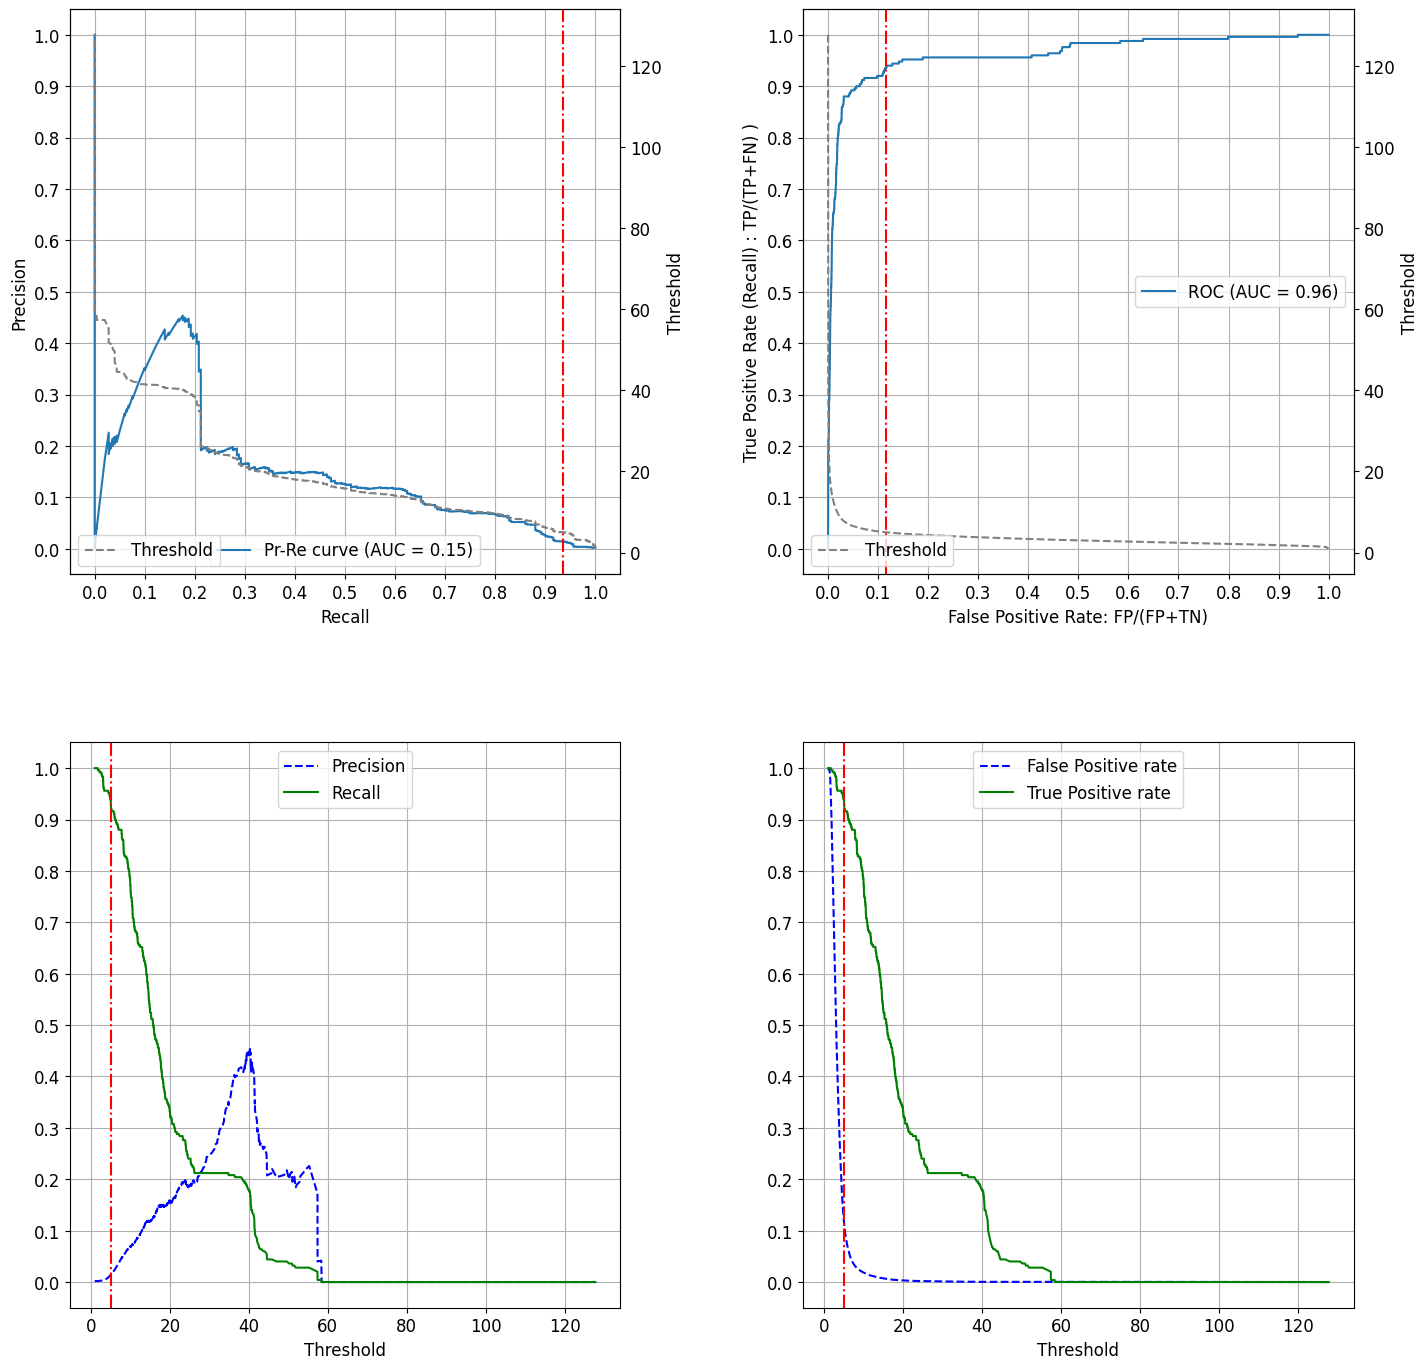

time: 1.86 s (started: 2025-11-14 22:59:04 +00:00)


In [15]:
threshold_selected = 5
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

## Evaluate the model on the test set

In [16]:
X_test_scaled = scaler.transform(X_test)

time: 28.8 ms (started: 2025-11-14 22:59:06 +00:00)


In [17]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)


4451/4451 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Precision: 0.013247404224847834
Recall:  0.9173553719008265
False Positive Rate: 0.11631800340456662
time: 7.83 s (started: 2025-11-14 22:59:06 +00:00)


* Precision 1.3%: when the model says "anomaly!", it is right 1.3% of the time.
* Recall 89%: the model captures 89% of the anomalies
* False positive rate 11%: 11% of normal samples are erroneously classified as anomalies

Normalized confusion matrix
[[0.883682   0.116318  ]
 [0.08264463 0.91735537]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

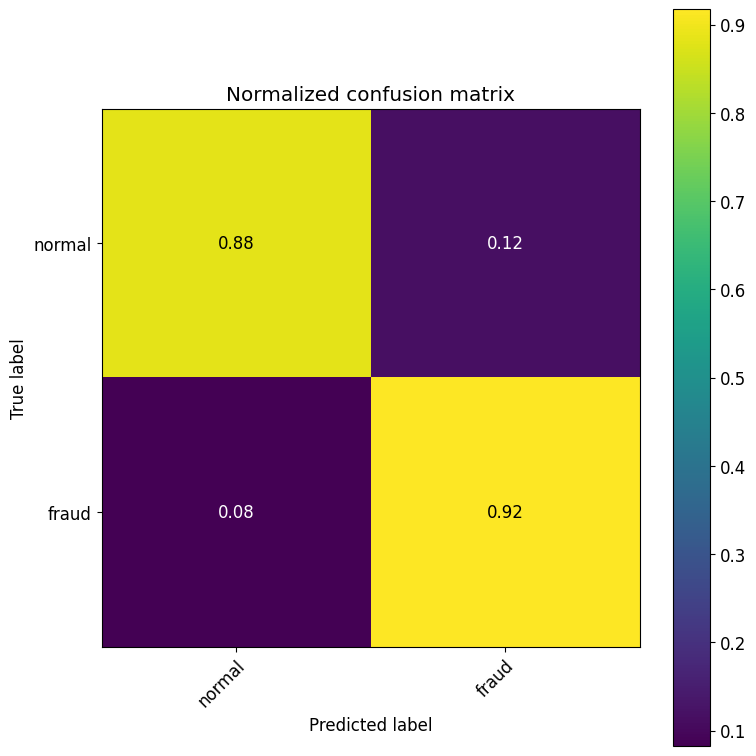

time: 272 ms (started: 2025-11-14 22:59:14 +00:00)


In [18]:
class_names = np.array(["normal", "fraud"])
plot_conf_mat(y_test, y_pred, class_names)

The model is not bad, but we can further improve it.

# Second autoencoder: only using normal samples

We now train the auto-ecoder only on the normal samples

In [19]:
# Select the normal samples
normal_samples_idx = [i for i in range(len(y_train)) if y_train[i]==0 ]
print("Found ", len(normal_samples_idx), "normal samples over ", len(y_train))

X_tr_normal = X_tr_scaled[normal_samples_idx, :]
X_tr_normal.shape

Found  142153 normal samples over  142403


(142153, 29)

time: 45.5 ms (started: 2025-11-14 22:59:14 +00:00)


In [20]:
model = make_autoencoder(layer_sizes=first_architecture, learning_rate=0.005)

time: 59.8 ms (started: 2025-11-14 22:59:14 +00:00)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


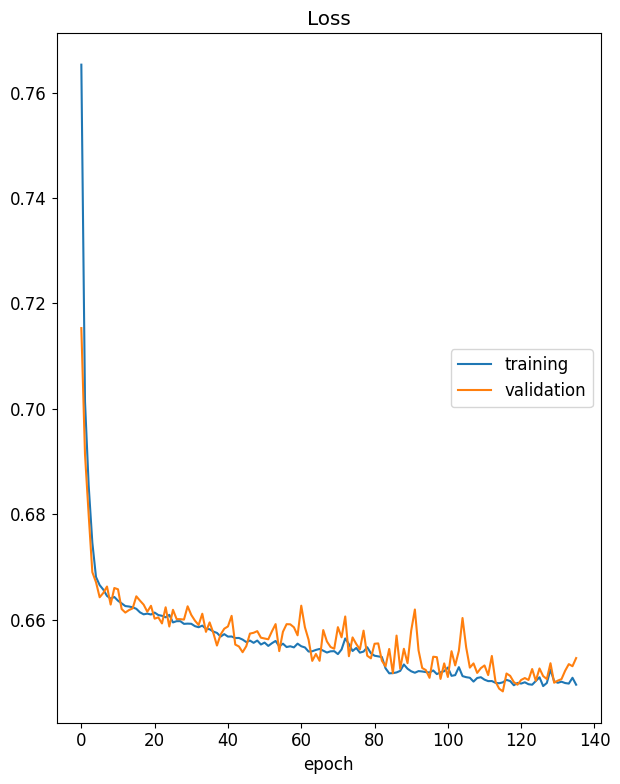

Loss
	training         	 (min:    0.647, max:    0.765, cur:    0.648)
	validation       	 (min:    0.646, max:    0.715, cur:    0.653)
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6392 - val_loss: 0.6527
Epoch 136: early stopping
Restoring model weights from the end of the best epoch: 116.
time: 25min 12s (started: 2025-11-14 22:59:14 +00:00)


In [21]:
nn_file = my_path + 'nn-normal-samples-lr_0.005.h5'
history = train_model(model, nn_file, X_tr_normal, X_tr_normal, seed=5,
                      max_epochs=200)

In [22]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

4451/4451 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
time: 9.54 s (started: 2025-11-14 23:24:27 +00:00)


Precision= 0.01363932870782186
Recall= 0.92
False Positive Rate =  0.11700773110662455
True Positive Rate =  0.92


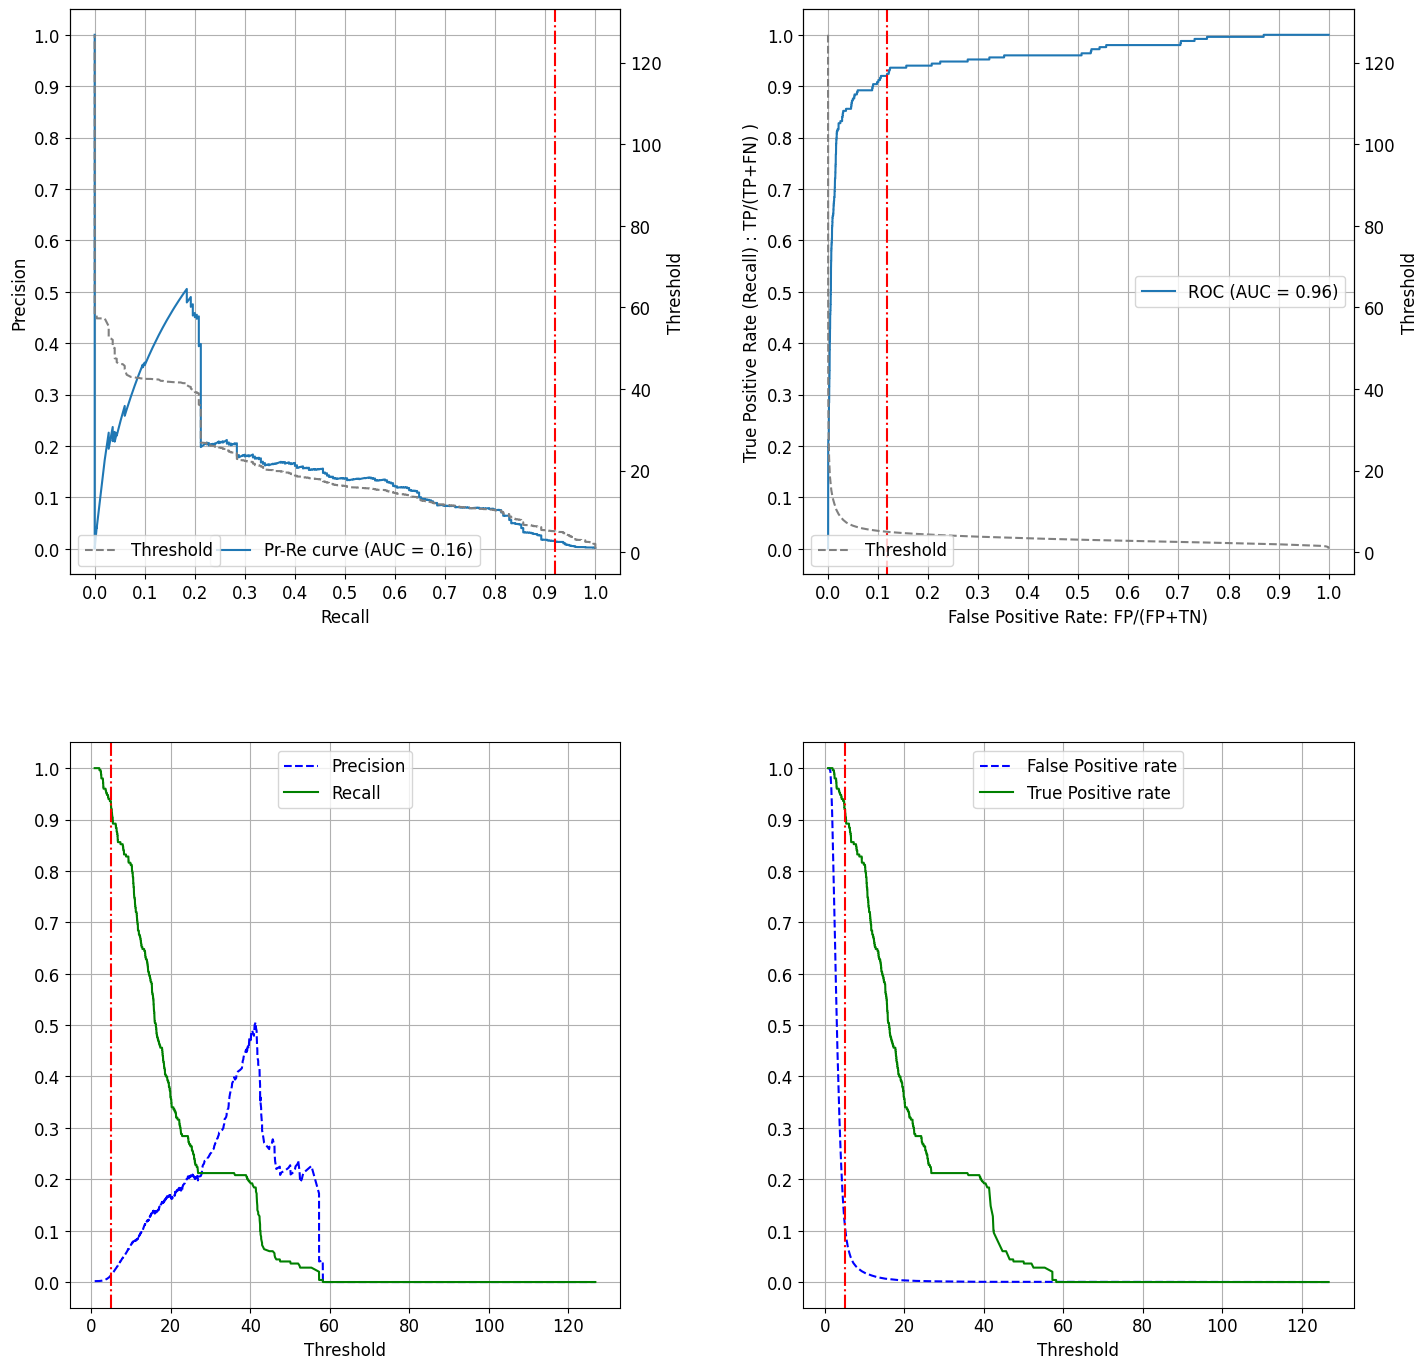

time: 1.47 s (started: 2025-11-14 23:24:36 +00:00)


In [23]:
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

In [24]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

4451/4451 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Precision: 0.01293823038397329
Recall:  0.8966942148760331
False Positive Rate: 0.11645165374713355
time: 8.57 s (started: 2025-11-14 23:24:38 +00:00)


Normalized confusion matrix
[[0.88354835 0.11645165]
 [0.10330579 0.89669421]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

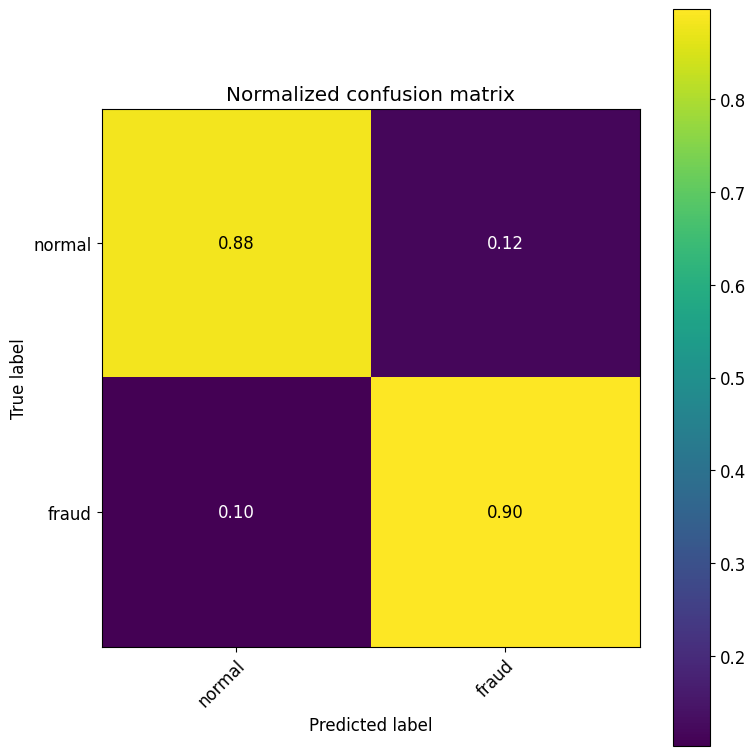

time: 250 ms (started: 2025-11-14 23:24:46 +00:00)


In [25]:
plot_conf_mat(y_test, y_pred, class_names)

The performance are a not better than before

# Deep autoencoder



In [26]:
deep_architecture = [25, 20, 15, 10, 15, 20, 25, n_features]

time: 502 µs (started: 2025-11-14 23:24:46 +00:00)


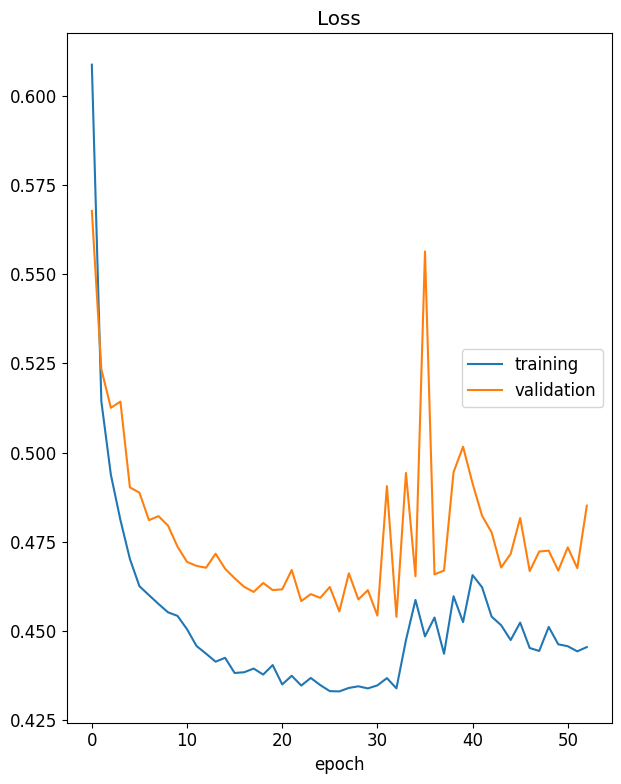

Loss
	training         	 (min:    0.433, max:    0.609, cur:    0.445)
	validation       	 (min:    0.454, max:    0.568, cur:    0.485)
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.4628 - val_loss: 0.4851
Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 33.
time: 10min 48s (started: 2025-11-14 23:24:46 +00:00)


In [27]:
model = make_autoencoder(layer_sizes=deep_architecture, learning_rate=0.005)

nn_file = my_path + 'deep-lr_0.005.h5'
history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5,
                      max_epochs=200)

In [28]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)


4451/4451 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
time: 20.6 s (started: 2025-11-14 23:35:35 +00:00)


Precision= 0.028348869876133317
Recall= 0.888
False Positive Rate =  0.053526833763620885
True Positive Rate =  0.888


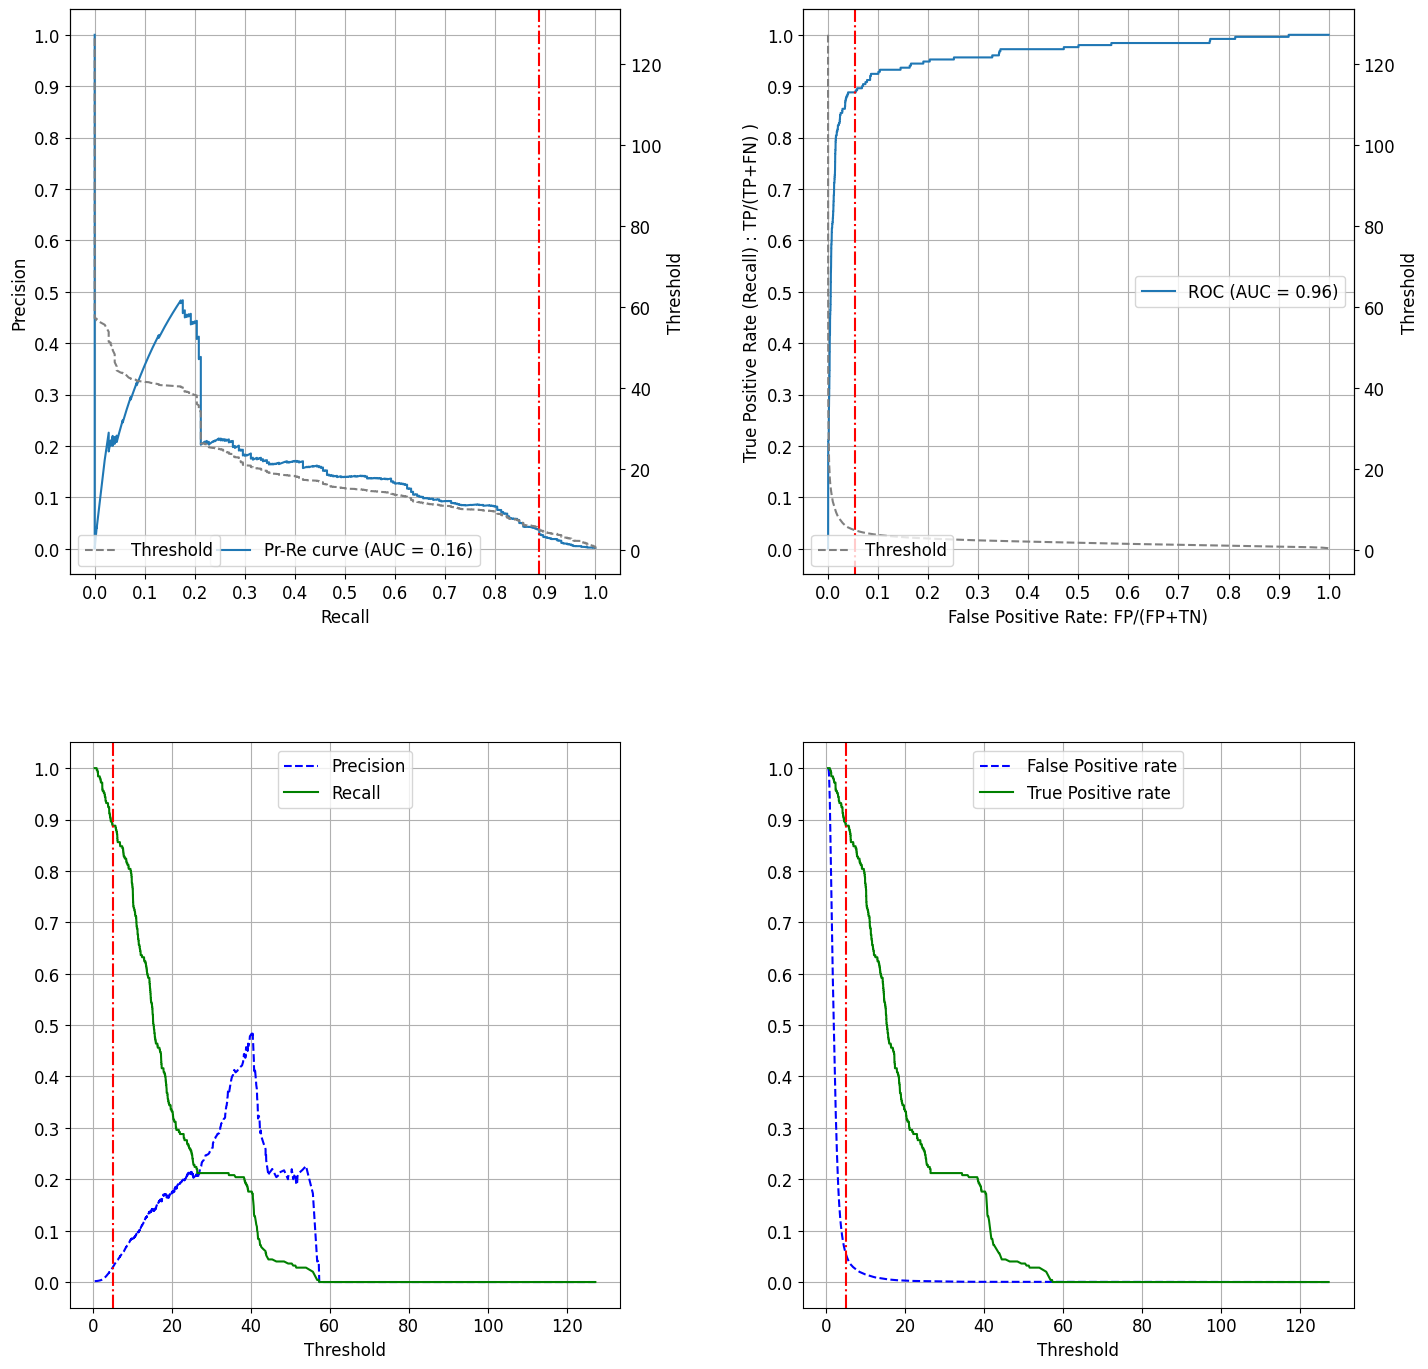

time: 1.67 s (started: 2025-11-14 23:35:55 +00:00)


In [29]:
threshold_selected = 5
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

In [30]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

4451/4451 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Precision: 0.027219701879455604
Recall:  0.8677685950413223
False Positive Rate: 0.05279188531393762
time: 8.55 s (started: 2025-11-14 23:35:57 +00:00)


Normalized confusion matrix
[[0.94720811 0.05279189]
 [0.1322314  0.8677686 ]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

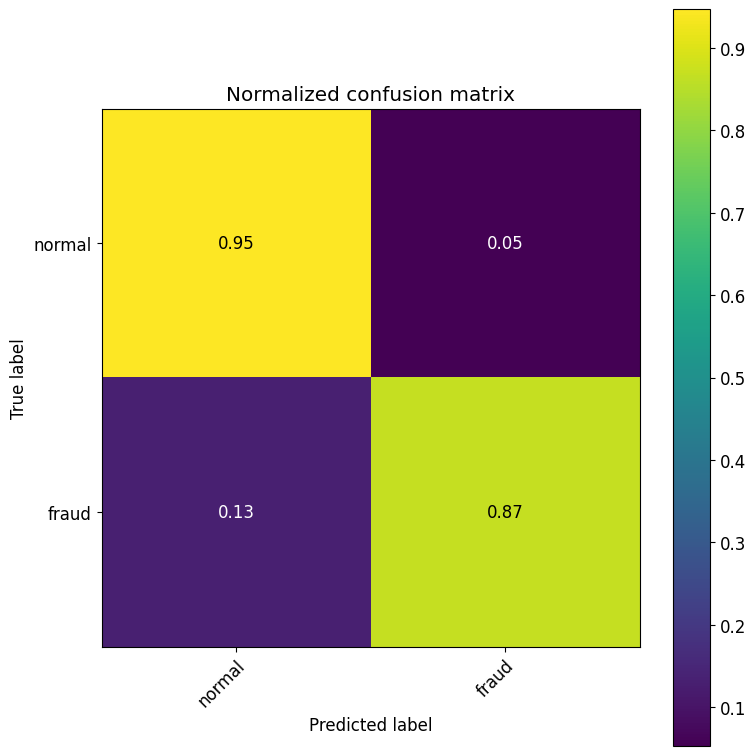

time: 296 ms (started: 2025-11-14 23:36:05 +00:00)


In [31]:
plot_conf_mat(y_test, y_pred, class_names)

Let's try with a smaller learning rate

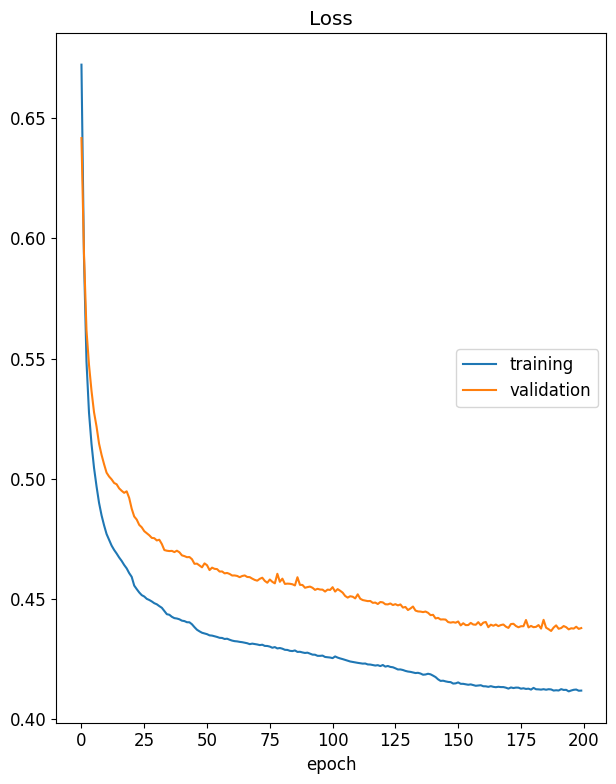

Loss
	training         	 (min:    0.412, max:    0.672, cur:    0.412)
	validation       	 (min:    0.437, max:    0.642, cur:    0.438)
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.4304 - val_loss: 0.4380
Restoring model weights from the end of the best epoch: 188.
time: 39min 3s (started: 2025-11-14 23:36:06 +00:00)


In [32]:
nn_file = my_path + 'deep-lr_0.001.h5'
model = make_autoencoder(layer_sizes=deep_architecture, learning_rate=0.001)
history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5,
                      max_epochs=200)

Google disconnected me. I will recover the last model.

In [34]:
from keras.models import load_model
nn_file = my_path + 'deep-lr_0.001.h5'
model = load_model(nn_file)

time: 1.46 s (started: 2025-11-15 00:19:49 +00:00)


In [35]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)


4451/4451 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
time: 9.77 s (started: 2025-11-15 00:19:59 +00:00)


Precision= 0.018173122907699665
Recall= 0.912
False Positive Rate =  0.08665311319493785
True Positive Rate =  0.912


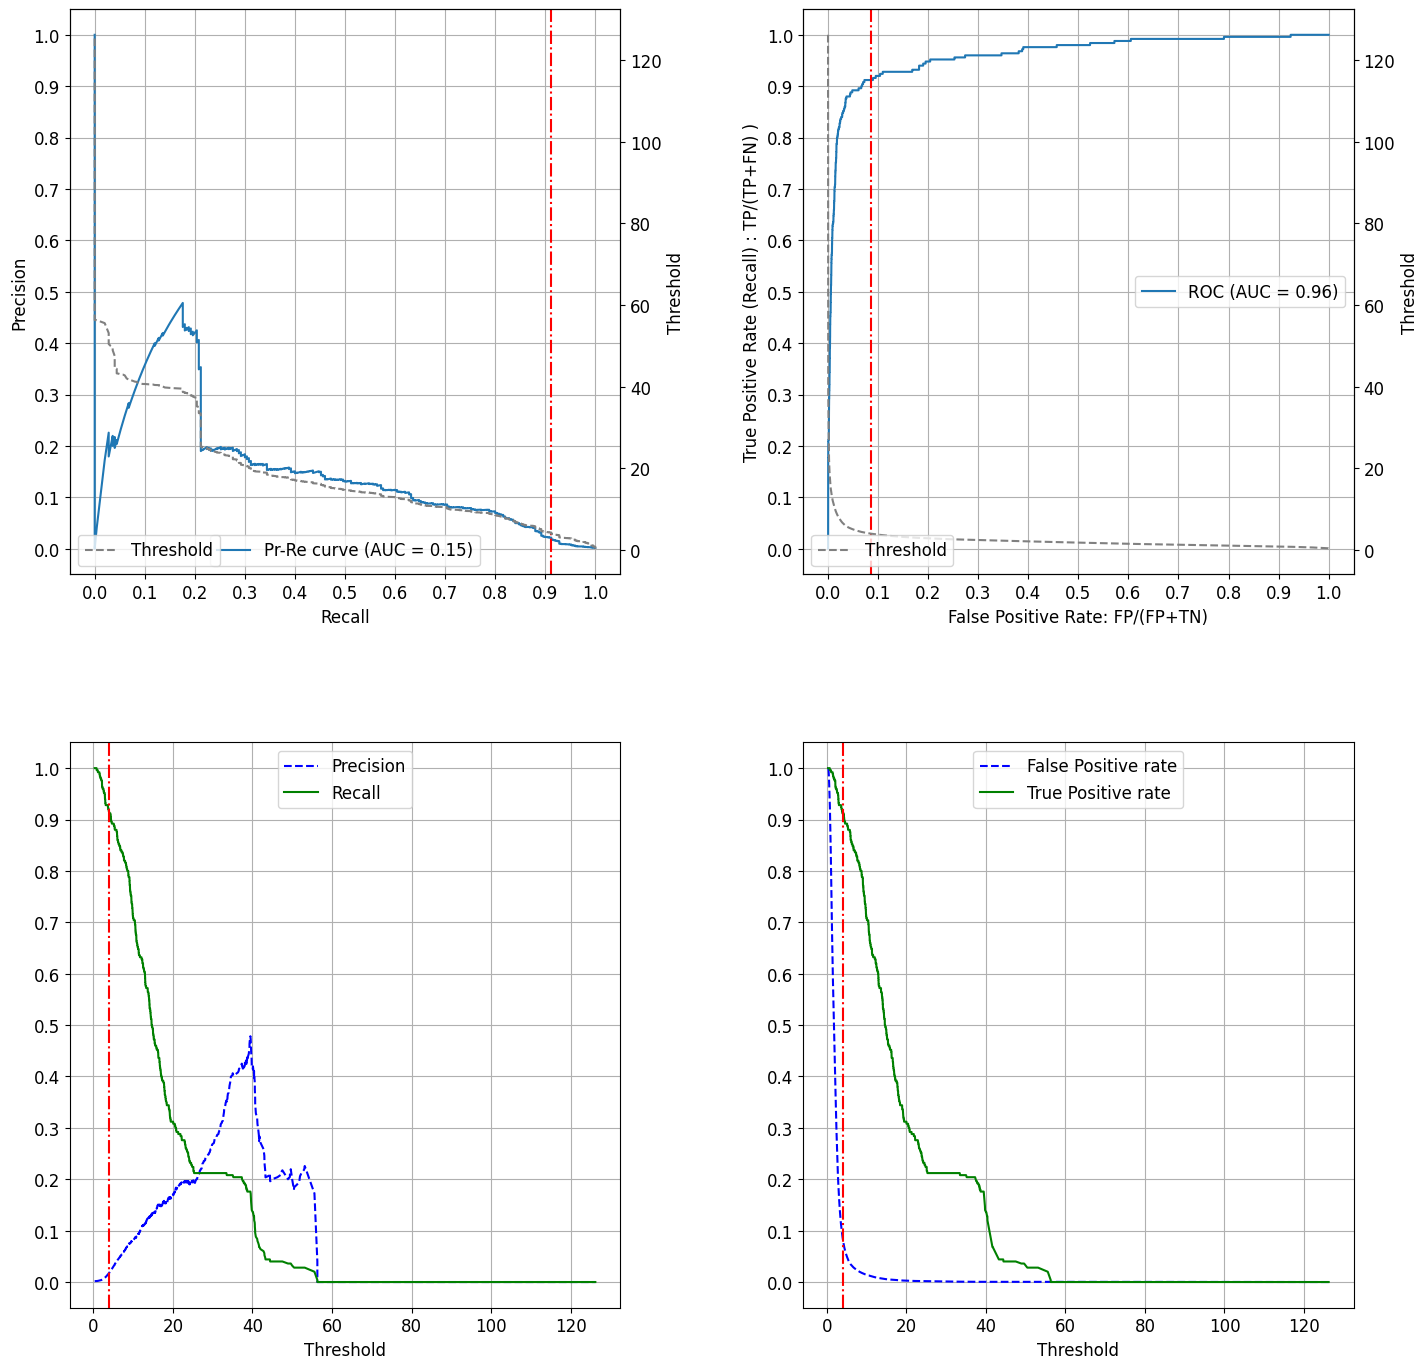

time: 1.44 s (started: 2025-11-15 00:20:08 +00:00)


In [36]:
threshold_selected = 4
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

In [37]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

4451/4451 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Precision: 0.017038636909047278
Recall:  0.8801652892561983
False Positive Rate: 0.08643660049802337
time: 9.14 s (started: 2025-11-15 00:20:10 +00:00)


# Other examples of Autoencoders for anomaly detection

* Application of autoencoders to the same dataset: Ch.8 of A. Patel, Hands-on unsupervised learning using Python, O'Reilly, 2019
* [Handwritten digits](https://visualstudiomagazine.com/articles/2019/03/01/neural-anomaly-detection-using-keras.aspx)